Revert Classification
===

Building a classifier to predict reverts and produce calibrated propensity scores for being reverted.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import os
from tqdm import tqdm
import bz2
import sqlite3
import difflib
import gzip
import json
import re
import hashlib
from datetime import datetime
from datetime import timezone
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [4]:
import sklearn
import sklearn.ensemble
import sklearn.metrics
import sklearn.calibration

In [5]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [6]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [7]:
stub_history_dir = os.path.join(derived_data_dir, 'stub-history-all-revisions')
stub_history_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions'

In [8]:
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
working_dir = os.path.join(derived_data_dir, 'audit')
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit'

### Data loading and cleaning

In [9]:
# read in the sample dataframe
s = datetime.now()
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
sample3_filepath = os.path.join(revision_sample_dir, 'sample3_all.pkl')
rev_df = pd.read_pickle(sample3_filepath)
print(f"Sample 3 data loaded in {datetime.now() - s}.")
len(rev_df)

Sample 3 data loaded in 0:00:28.275384.


33964442

In [10]:
rev_df.head()

,page_id,rev_id,rev_timestamp,is_revert_target,is_reverted,is_reverting,is_sample_eligible,prev_rev_id,next_rev_id,prev_rev_timestamp,next_rev_timestamp,reverted_rev_ids,reverting_rev_id,reverting_rev_timestamp
1,12,818613649,1515102279,0,0,0,True,818611292,818624114,1515101356,1515106953,[],-1,-1
2,12,818624114,1515106953,1,0,0,True,818613649,820024812,1515102279,1515798752,[],-1,-1
3,12,820024812,1515798752,0,1,0,True,818624114,820025687,1515106953,1515799060,[],820025687,1515799060
4,12,820025687,1515799060,0,0,1,True,820024812,820703495,1515798752,1516095884,[820024812],-1,-1
5,12,820703495,1516095884,0,0,0,True,820025687,821673418,1515799060,1516597634,[],-1,-1


In [11]:
# Load the features
s = datetime.now()
labeled_revs_dir = os.path.join(derived_data_dir, 'labeled-revs')
#sample2_damaging_filepath = os.path.join(labeled_revs_dir, 'sample2.mock.damaging.tsv')
sample3_damaging_filepath = os.path.join(labeled_revs_dir, 'sample3-features', 'sample3.damaging.2020-07-11T15:11:15Z.tsv')
features_df = pd.read_csv(sample3_damaging_filepath, sep='\t', header=0)
print(f"Features data loaded in {datetime.now() - s}.")
len(features_df)

Features data loaded in 0:00:39.050684.


4005652

In [12]:
# drop the useless 'damaging' column
features_df = features_df.drop(columns='damaging')

In [13]:
# load in the rev_ids that correspond to the feature data
#cache_filepath = os.path.join(labeled_revs_dir, 'sample2.mock.w_cache.json')
cache_filepath = os.path.join(labeled_revs_dir, 'sample3-features', 'sample3.mock.w_cache.2020-07-11T15:11:15Z.json')
cache_rev_id_list = []
with open(cache_filepath, 'r') as infile:
    for line in tqdm(infile, total=len(features_df)):
        rev = json.loads(line)
        rev_id = rev['rev_id']
        cache_rev_id_list.append(rev_id)

100%|██████████| 4005652/4005652 [02:13<00:00, 29902.51it/s]


In [14]:
assert len(cache_rev_id_list) == len(features_df)

In [15]:
cache_rev_id_set = set(cache_rev_id_list)
len(cache_rev_id_set)

4005602

In [16]:
last_rev = cache_rev_id_list[-1]
last_rev

826425205

In [17]:
# every rev_id in the cache should ALSO be in the rev_df
assert len(cache_rev_id_set & set(rev_df.rev_id)) == len(cache_rev_id_set), len(cache_rev_id_set & set(rev_df.rev_id))

In [18]:
# set the analysis start time to be the beginning of 2018
analysis_start_date = datetime.fromisoformat('2018-01-01')
analysis_start_date = analysis_start_date.replace(tzinfo=timezone.utc)
analysis_start_timestamp = int(analysis_start_date.timestamp())
print(f"Starting analysis from {datetime.utcfromtimestamp(analysis_start_timestamp)}")

Starting analysis from 2018-01-01 00:00:00


In [19]:
analysis_end_timestamp = rev_df[rev_df.rev_id == last_rev].rev_timestamp.iloc[0]
#analysis_end_timestamp = np.max(rev_df[rev_df.rev_id.isin(cache_rev_id_set)].rev_timestamp)
print(f"Using revisions up to {datetime.utcfromtimestamp(analysis_end_timestamp)}")

Using revisions up to 2018-02-19 07:18:15


In [20]:
# mostly to save memory, we trim out unneeded data in the rev_df
rev_df = rev_df[(rev_df.rev_timestamp <= analysis_end_timestamp)&(rev_df.rev_timestamp >= analysis_start_timestamp)]
len(rev_df)

4025634

In [21]:
# Read the revert info
s = datetime.now()
stub_history_reverts_dir = os.path.join(derived_data_dir, 'stub-history-reverts')
revert_df_filepath = os.path.join(stub_history_reverts_dir, 'revert_df.pkl')
revert_df = pd.read_pickle(revert_df_filepath)
print(f"Loaded revert data in {datetime.now() - s}.")
len(revert_df)

Loaded revert data in 0:00:27.189379.


5992682

In [22]:
revert_df.head()

,page_id,reverted_count,reverting_rev_id,reverting_timestamp,reverting_user_text,reverting_user_id,reverted_to_rev_id,reverted_to_timestamp,reverted_to_user_text,reverted_to_user_id,reverted_rev_ids,reverted_timestamps,reverted_user_texts,reverted_user_ids,reverting_user_is_anonymous,reverted_to_user_is_anonymous,reverted_users_is_anonymous
0,18754764,1,902766646,1561105801,Malcolmxl5,4076676.0,874884880,1545481829,Hmains,508734.0,[900328973],[1559706521],[2601:199:417F:8EED:A0B0:A6B5:3457:A9B4],[None],False,False,[True]
1,18754831,2,818980415,1515284429,BrownHairedGirl,754619.0,743241620,1475970276,Emir of Wikipedia,28856560.0,"[757539852, 775847398]","[1483188655, 1492452285]","[Ser Amantio di Nicolao, Emir of Wikipedia]","[753665, 28856560]",False,False,"[False, False]"
2,18754831,1,932235094,1577204938,UA3,25923702.0,918313790,1569654385,Monkbot,20483999.0,[932233860],[1577204033],[Qowa],[37692801],False,False,[False]
3,18754864,1,853153047,1533256539,Beetstra,855858.0,831996274,1521801439,KolbertBot,31691822.0,[846149041],[1529188413],[Lepidoptera~plwiki],[24892933],False,False,[False]
4,18754916,1,882182106,1549557841,Number 57,327289.0,847748130,1530126769,CitationCleanerBot,15270283.0,[882125775],[1549520001],[Huldra],[410653],False,False,[False]


In [23]:
is_self_revert_list = []
for row in tqdm(revert_df.itertuples(), total=len(revert_df)):
    is_self_revert = row.reverting_user_text in row.reverted_user_texts
    is_self_revert_list.append(is_self_revert)
revert_df['is_self_revert'] = is_self_revert_list

100%|██████████| 5992682/5992682 [00:19<00:00, 311734.57it/s]


In [24]:
analysis_rev_ids = set(rev_df.rev_id)
revert_subset = revert_df[revert_df.reverting_rev_id.isin(analysis_rev_ids)].copy()
len(revert_subset), len(revert_subset) / len(revert_df)

(427375, 0.07131614859590414)

In [25]:
reverted_rev_ids = set()
# only count it as a reverted revision if it was not a self-revert
# and it was reverted within one week
threshold = 60 * 60 * 24 * 7 
rs = revert_subset[~revert_subset.is_self_revert]
for row in tqdm(rs.itertuples(), total=len(rs)):
    reverting_timestamp = row.reverting_timestamp
    for rev_id, timestamp in zip(row.reverted_rev_ids, row.reverted_timestamps):
        if reverting_timestamp - timestamp <= threshold:
            reverted_rev_ids.add(rev_id)
len(reverted_rev_ids)

100%|██████████| 377374/377374 [00:01<00:00, 199358.54it/s]


501159

In [26]:
is_reverted = [rev_id in reverted_rev_ids for rev_id in cache_rev_id_list]
features_df['is_reverted'] = is_reverted
np.sum(features_df.is_reverted), np.sum(features_df.is_reverted) / len(features_df)

(411650, 0.10276728981948506)

### Fit classification models

In [ ]:
df = features_df.sample(frac=1)

In [44]:
# define the classifier based on the enwiki tuning report
# hyperparameters set from: https://github.com/wikimedia/editquality/blob/master/tuning_reports/enwiki.damaging.md
clf = sklearn.ensemble.GradientBoostingClassifier(
    learning_rate=0.01, 
    n_estimators=700, 
    max_features='log2', 
    max_depth=5
)

In [42]:
clf = sklearn.linear_model.LogisticRegression(
    C=1.0,
    solver='lbfgs'
)

In [45]:
kf = sklearn.model_selection.KFold(n_splits=5)
train_accs = []
test_accs = []
roc_auc_list = []

train_label_list = []
test_label_list = []
train_proba_list = []
test_proba_list = []

for train_idx, test_idx in kf.split(df):
    train = df.loc[train_idx]
    test = df.loc[test_idx]
    
    # store the labels for future calibration
    train_label_list.append(train.iloc[:,-1].to_numpy())
    test_label_list.append(test.iloc[:,-1].to_numpy())
    
    # train the model
    md = clf.fit(train.iloc[:,:-1], train.iloc[:,-1])
    
    # predict with the model
    y_pred_train = md.predict(train.iloc[:,:-1])
    y_pred_train_proba = md.predict_proba(train.iloc[:,:-1])[:,1]
    y_pred_test = md.predict(test.iloc[:,:-1])
    y_pred_test_proba = md.predict_proba(test.iloc[:,:-1])[:,1]
    train_proba_list.append(y_pred_train_proba)
    test_proba_list.append(y_pred_test_proba)
    
    # compute metrics
    acc_train = np.sum(y_pred_train == train.is_reverted) / len(y_pred_train)
    acc_test = np.sum(y_pred_test == test.is_reverted) / len(y_pred_test)
    roc_auc = sklearn.metrics.roc_auc_score(test.is_reverted, y_pred_test_proba)
    
    # save and print metrics
    train_accs.append(acc_train)
    test_accs.append(acc_test)
    roc_auc_list.append(roc_auc)
    print(f"Train: {acc_train*100:.3f}%; test: {acc_test*100:.3f}%; test ROC AUC: {roc_auc:.4f}")
print(f"CV train accuracy: {np.mean(train_accs)*100:.3f}%; CV test accuracy: {np.mean(test_accs)*100:.3f}%; test ROC AUC: {np.mean(roc_auc_list):.4f}")

Train: 91.945%; test: 92.052%; test ROC AUC: 0.8355
Train: 91.937%; test: 92.054%; test ROC AUC: 0.8330
Train: 91.974%; test: 91.908%; test ROC AUC: 0.8331
Train: 92.009%; test: 91.800%; test ROC AUC: 0.8379
Train: 92.002%; test: 91.795%; test ROC AUC: 0.8353
CV train accuracy: 91.973%; CV test accuracy: 91.922%; test ROC AUC: 0.8350


In [29]:
clf1 = sklearn.ensemble.GradientBoostingClassifier(
    learning_rate=0.01, 
    n_estimators=700, 
    max_features='log2', 
    max_depth=5
)

clf2 = sklearn.linear_model.LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs'
)

clf3 = sklearn.linear_model.LogisticRegression(
    penalty='none',
    solver='lbfgs', # TODO try saga
    max_iter=1000
)

train, test = sklearn.model_selection.train_test_split(df, test_size=0.2)
#train = df.loc[train_idx]
#test = df.loc[test_idx]
X_train = sklearn.preprocessing.scale(train.iloc[:,:-1])
X_test = sklearn.preprocessing.scale(test.iloc[:,:-1])

clf_results = []
for clf in [clf3, clf2, clf1]:
    s = datetime.now()
    print(clf)

    
    # train the model
    md = clf.fit(X_train, train.iloc[:,-1])
    
    # predict with the model
    y_pred_test = md.predict(X_test)
    y_pred_test_proba = md.predict_proba(X_test)[:,1]
    y_test = test.is_reverted
    clf_results.append([y_pred_test, y_pred_test_proba, y_test])
    print(f"Training completed in {datetime.now() - s}.")


LogisticRegression(max_iter=1000, penalty='none')
Training completed in 0:02:14.465535.
LogisticRegression()


/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training completed in 0:00:42.751321.
GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='log2',
                           n_estimators=700)
Training completed in 0:19:39.882873.


KR (no reg); accuracy: 90.114%; test ROC AUC: 0.8407; % damaging; 0.015849626966106024
              precision    recall  f1-score   support

       False       0.91      0.99      0.95    260438
        True       0.58      0.09      0.16     29348

    accuracy                           0.90    289786
   macro avg       0.74      0.54      0.55    289786
weighted avg       0.87      0.90      0.87    289786


LR (L2 reg); accuracy: 90.127%; test ROC AUC: 0.8406; % damaging; 0.015614971047600644
              precision    recall  f1-score   support

       False       0.91      0.99      0.95    260438
        True       0.58      0.09      0.16     29348

    accuracy                           0.90    289786
   macro avg       0.74      0.54      0.55    289786
weighted avg       0.87      0.90      0.87    289786


GB Tree; accuracy: 90.983%; test ROC AUC: 0.8556; % damaging; 0.03081239259315495
              precision    recall  f1-score   support

       False       0.92      0.99

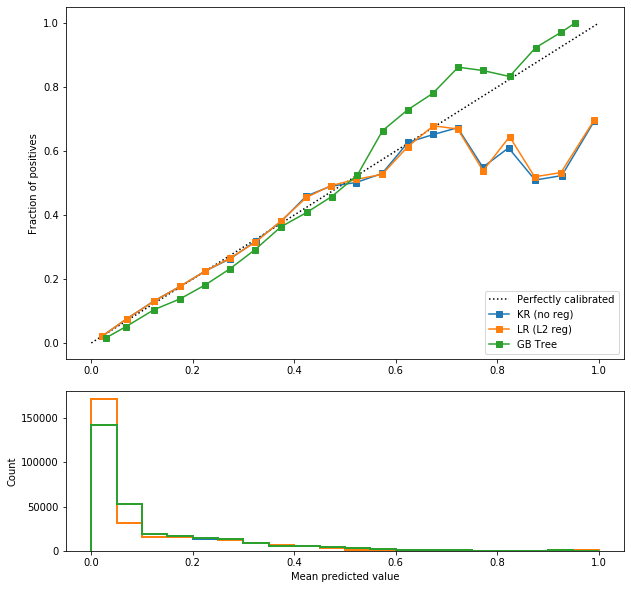

In [35]:
fig = plt.figure(0, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for label, tup in zip(['LR (no reg)', 'LR (L2 reg)', 'GB Tree'], clf_results):
    y_pred_test, y_pred_test_proba, y_test = tup
    frac_of_pos, mean_pred_value = sklearn.calibration.calibration_curve(y_test, y_pred_test_proba, n_bins=20)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=label)
    ax1.set_ylabel("Fraction of positives")
    ax2.hist(y_pred_test_proba, range=(0, 1), bins=20, histtype="step", lw=2, log=False)
    
    acc_test = np.sum(y_pred_test == y_test) / len(y_pred_test)
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_test_proba)
    print(f"{label}; accuracy: {acc_test*100:.3f}%; test ROC AUC: {roc_auc:.4f}; % reverted; {np.sum(y_pred_test) / len(y_test)}")
    print(sklearn.metrics.classification_report(y_test, y_pred_test))
    print()
    
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")

plt.show()

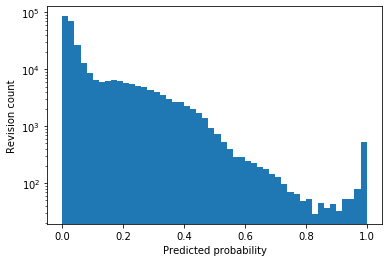

In [32]:
plt.hist(clf_results[0][1], bins=50, log=True)
plt.xlabel("Predicted probability")
plt.ylabel("Revision count")
plt.show()

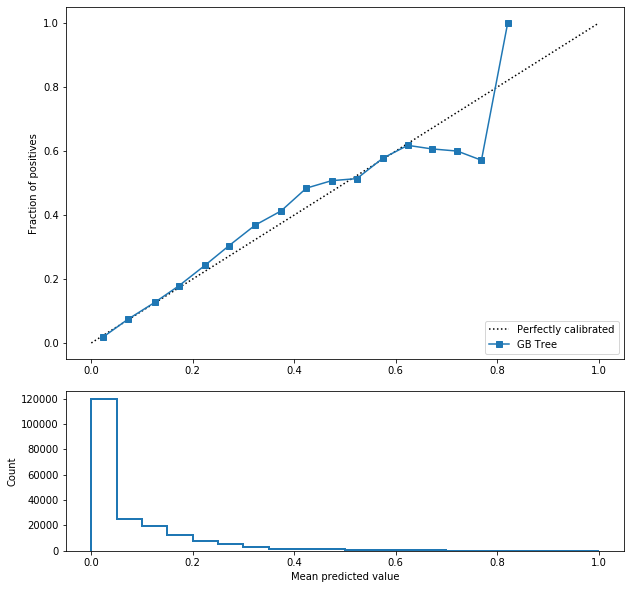

In [59]:

frac_of_pos, mean_pred_value = sklearn.calibration.calibration_curve(test.iloc[:,-1], y_pred_test_proba, 
                                                                     n_bins=20)

fig = plt.figure(0, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.plot(mean_pred_value, frac_of_pos, "s-", label='GB Tree')
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")

ax2.hist(y_pred_test_proba, range=(0, 1), bins=20, histtype="step", lw=2, log=False)
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")

plt.show()

In [64]:
print(sklearn.metrics.classification_report(test.iloc[:,-1], y_pred_test))

              precision    recall  f1-score   support

       False       0.92      0.99      0.96    182307
        True       0.57      0.08      0.15     16663

   micro avg       0.92      0.92      0.92    198970
   macro avg       0.75      0.54      0.55    198970
weighted avg       0.89      0.92      0.89    198970



In [ ]:
ores_df = pd.read_csv("/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit/sample3_ores_scores_calibrated.csv", header=0, index=None)
len(ores_df)

### Logistic regression classification

In [72]:
clf = sklearn.linear_model.LogisticRegression(
    penalty='none',
    solver='lbfgs', # TODO try saga
    max_iter=1000
)

In [73]:
df = features_df.sample(frac=1)
train, test = sklearn.model_selection.train_test_split(df, test_size=0.2)

In [74]:
s = datetime.now()

X_train = sklearn.preprocessing.scale(train.iloc[:,:-1])
X_test = sklearn.preprocessing.scale(test.iloc[:,:-1])

# train the model
md = clf.fit(X_train, train.iloc[:,-1])

# predict with the model
y_pred_test = md.predict(X_test)
y_pred_test_proba = md.predict_proba(X_test)[:,1]
y_test = test.is_reverted

print(f"Training completed in {datetime.now() - s}.")

Training completed in 0:09:46.366340.


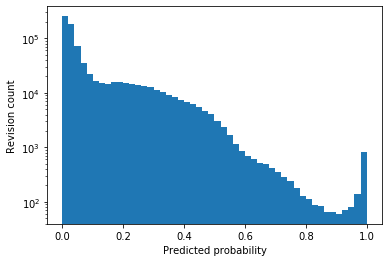

In [75]:
plt.hist(y_pred_test_proba, bins=50, log=True)
plt.xlabel("Predicted probability")
plt.ylabel("Revision count")
plt.show()

In [76]:
np.sum(y_pred_test) / len(y_pred_test)

0.0181243766624934

In [78]:
roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_test_proba)
roc_auc

0.8497455770241475

In [28]:
features_df['rev_id'] = cache_rev_id_list

In [41]:
clf = sklearn.linear_model.LogisticRegression(
    penalty='none',
    solver='lbfgs',
    max_iter=1000
)

revert_prob_list = []

df = features_df.sample(frac=1)
kf = sklearn.model_selection.KFold(n_splits=5)
all_start = datetime.now()
for train_idx, test_idx in kf.split(df):
    train = df.loc[train_idx].sample(n=1000000)
    test = df.loc[test_idx]
    s = datetime.now()
    
    X_train = sklearn.preprocessing.scale(train.iloc[:,:-2])
    X_test = sklearn.preprocessing.scale(test.iloc[:,:-2])
    
    # train the model
    md = clf.fit(X_train, train.iloc[:,-2])
    
    # predict with the model
    y_pred_test = md.predict(X_test)
    y_pred_test_proba = md.predict_proba(X_test)[:,1]
    
    # compute metrics
    #acc_train = np.sum(y_pred_train == train.is_reverted) / len(y_pred_train)
    acc_test = np.sum(y_pred_test == test.is_reverted) / len(y_pred_test)
    roc_auc = sklearn.metrics.roc_auc_score(test.is_reverted, y_pred_test_proba)
    revert_prob_list.extend([{'rev_id': rev_id, 'revert_prob': revert_prob} for rev_id, revert_prob in zip(test.rev_id, y_pred_test_proba)])
    print(f"{datetime.now() - s}; test acc: {acc_test*100:.3f}%; test ROC AUC: {roc_auc:.4f}")
print(f"{datetime.now() - all_start}")

0:01:42.495778; test acc: 90.263%; test ROC AUC: 0.8366
0:03:24.146148; test acc: 89.768%; test ROC AUC: 0.8412
0:01:42.880837; test acc: 89.457%; test ROC AUC: 0.8451


/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0:03:50.910636; test acc: 89.276%; test ROC AUC: 0.8492
0:02:21.200266; test acc: 91.125%; test ROC AUC: 0.8610
0:13:27.432114


In [42]:
revert_score_df = pd.DataFrame(revert_prob_list)
len(revert_score_df)

4005652

In [49]:
revert_score_df = pd.merge(revert_score_df, features_df[['rev_id', 'is_reverted']], on='rev_id', how='left')

In [50]:
revert_score_df.head()

,rev_id,revert_prob,is_reverted
0,872415232,0.053284,False
1,872415234,0.215013,False
2,872415235,0.008344,False
3,872415236,0.050808,False
4,872415237,0.009443,False


In [51]:
# save the scores
audit_dir = os.path.join(derived_data_dir, 'audit')
revert_score_filepath = os.path.join(audit_dir, 'sample3_revert_scores.csv')
revert_score_df.to_csv(revert_score_filepath, index=False)
revert_score_filepath

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit/sample3_revert_scores.csv'